In [1]:
import time
import img_utils
import metric_utils
from torch.optim import lr_scheduler
from torch import nn
from PIL import Image

from calrank import *

Setting Parameters

In [2]:
data_root = 'data/'
dataset = 'real'
img_num = 1
corruption = 'text' # Corruption method for corrupting image. Options are: [text | drop | block]
f_type = 'Laplace' # options are: [gamma_nuclear | LNN | Logarithm | ETP | Geman | Laplace]
lr = 0.1
lam=0.001
f_gamma = 500
f_lam = 1
step = 500
use_f = True

num_inv = 200
num_g = 20000
n = 5000
grad_mask = True
update_lr = True
lr_change_step = 100
lr_change_rate = 0.8

Training Process

In [3]:
X_gt, M_obs, observed, min_val, max_val = img_utils.load_data(data_root, dataset,img_num, corruption)
num_channels = M_obs.shape[-1]

# solve for complete image
total_time = 0
start = time.time()

gpu = try_gpu(0)
X_sol = np.copy(M_obs)
_mask = torch.tensor(observed,requires_grad=False,dtype=torch.float32,device=gpu)
# solve for completed matrix (complete matrix per channel)
num_channels = M_obs.shape[-1]
for c in range(num_channels):
    X = M_obs[..., c]  # initialize X_1 to M_obs
    gt = X_gt[..., c]
    mask = _mask[..., c]
    target = torch.tensor(X,requires_grad=False,dtype=torch.float32,device=gpu)
    w = torch.tensor(X,requires_grad=True,dtype=torch.float32,device=gpu)
    loss = nn.MSELoss(reduction='none')
    print("w.device:",w.device)
    print("w.shape",w.shape)

    # gamma_nuclear | LNN | Logarithm | ETP | Geman | Laplace
    if f_type == 'gamma_nuclear':
        parameters = parameters_gamma_nuclear_norm(gamma=f_gamma,lam=f_lam)
    elif f_type == 'LNN':
        parameters = parameters_LNN(lam=f_lam)
    elif f_type == 'Geman':
        parameters = parameters_Geman(gamma=f_gamma,lam=f_lam)
    elif f_type == 'Laplace':
        parameters = parameters_Laplace(gamma=f_gamma,lam=f_lam)
    elif f_type == 'ETP':
        parameters = parameters_ETP(gamma=f_gamma,lam=f_lam)

    optimizer = torch.optim.Adam([w], lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_change_step, gamma=lr_change_rate)
    for i in range(step):
        optimizer.zero_grad()
        l1 = (loss(target, w) * mask.float()).sum()
        non_zero_elements = mask.sum()
        l1 = l1 / non_zero_elements
        if use_f:
            l2 = lam * cal_rank_f_woinverse(w,parameters=parameters,num_inv=num_inv,num_g=num_g,gpu=gpu,n=n)
        else:
            l2 = lam * cal_rank_nuclear_woinverse(w,num_inv=num_inv,num_g=num_g,gpu=gpu,n=n)
        l = l1 + l2
        if i%20==0:
            print(i,"l:",l.data)
        l.backward()
        if grad_mask:
            w.grad = w.grad * (1-mask.float())

        optimizer.step()
        if update_lr:
            scheduler.step()

    X_sol[..., c] = w.cpu().detach().numpy()


end = time.time()
print('Runtime: %f'%(end-start))
total_time += (end-start)


X_gt.shape (300, 300, 3)
w.device: cuda:0
w.shape torch.Size([300, 300])
0 l: tensor(0.0016, device='cuda:0')
20 l: tensor(0.0010, device='cuda:0')
40 l: tensor(0.0009, device='cuda:0')
60 l: tensor(0.0009, device='cuda:0')
80 l: tensor(0.0009, device='cuda:0')
100 l: tensor(0.0009, device='cuda:0')
120 l: tensor(0.0009, device='cuda:0')
140 l: tensor(0.0009, device='cuda:0')
160 l: tensor(0.0009, device='cuda:0')
180 l: tensor(0.0009, device='cuda:0')
200 l: tensor(0.0009, device='cuda:0')
220 l: tensor(0.0009, device='cuda:0')
240 l: tensor(0.0009, device='cuda:0')
260 l: tensor(0.0009, device='cuda:0')
280 l: tensor(0.0009, device='cuda:0')
300 l: tensor(0.0009, device='cuda:0')
320 l: tensor(0.0009, device='cuda:0')
340 l: tensor(0.0009, device='cuda:0')
360 l: tensor(0.0009, device='cuda:0')
380 l: tensor(0.0009, device='cuda:0')
400 l: tensor(0.0009, device='cuda:0')
420 l: tensor(0.0009, device='cuda:0')
440 l: tensor(0.0009, device='cuda:0')
460 l: tensor(0.0009, device='cuda:0

Result Display

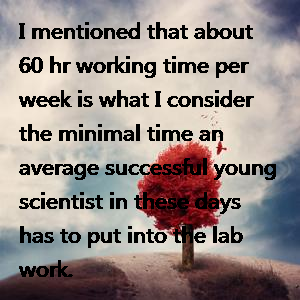

In [4]:
scaled_array = np.interp(M_obs, (0, 1), (0, 255)).astype('uint8')
obs = Image.fromarray(scaled_array)
display(obs)


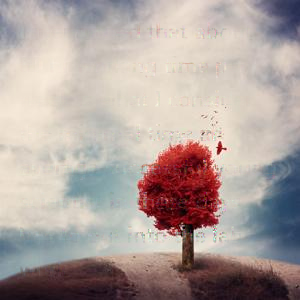

In [5]:
scaled_array = np.interp(X_sol, (0, 1), (0, 255)).astype('uint8')
obs = Image.fromarray(scaled_array)
display(obs)